In [1]:
import sys
sys.path.append('../')

import msgpack
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict
from typing import Union, Dict
from gerador import pypsg

In [163]:
def converter_configuracao(configuracao: Union[Dict, str], para_dataframe: bool = True) -> Union[pd.DataFrame, str]:
    """
    Converte uma configuração de string para DataFrame ou vice-versa.

    Args:
        configuracao (Union[Dict, str]): Configuração a ser convertida.
        para_dataframe (bool, optional): Se True, converte para DataFrame. 
        Se False, converte para string.

    Raises:
        ValueError: Se o tipo de dado da configuração não for suportado para conversão.

    Returns:
        Union[pd.DataFrame, str]: Configuração convertida.
    """
    if isinstance(configuracao, str):
        if para_dataframe:
            config_dict = {chave.strip("<"): [valor.strip()] 
                           for linha in configuracao.split("\n") if linha.strip() 
                           for chave, valor in [linha.split(">", 1)]}
            return pd.DataFrame(config_dict)
        else:
            return configuracao
    elif isinstance(configuracao, dict):
        if para_dataframe:
            return pd.DataFrame.from_dict(configuracao, orient="index").T
        else:
            return "\n".join([f"<{chave}>{valor}" for chave, valor in configuracao.items()])
    else:
        raise ValueError("Tipo de dado não suportado para conversão")


class EspectroAnalise:
    """
    Classe base para análise de espectros.

    Esta classe fornece métodos para analisar espectros, incluindo a conversão de espectros para DataFrames pandas,
    a plotagem de espectros e a exibição de cabeçalhos de resultados de espectros.
    """
    
    def __init__(self, resultado: Dict):
        """
        Inicializa a classe com um resultado de espectro.
        
        Args:
            resultado (Dict): Um dicionário contendo o resultado do espectro.
        """
        self._resultado = resultado
        self._configurar_matplotlib()
    
    def _configurar_matplotlib(self):
        """
        Configura os parâmetros do matplotlib.
        """
        plt.rcParams.update({
            "axes.spines.right": False,
            "axes.spines.top": False,
            "font.size": 12,
            "axes.labelsize": 12,
            "axes.titlesize": 12,
            "legend.fontsize": 10,
            "xtick.labelsize": 10,
            "ytick.labelsize": 10,
            "figure.figsize" : (10, 4)
            })

    def mostrar_cabecalho(self):
        """
        Mostra o cabeçalho do resultado do espectro.

        Este método imprime o cabeçalho do resultado do espectro. Se nenhum cabeçalho estiver disponível,
        ele imprimirá "Nenhum cabeçalho disponível".
        """
        cabecalho = self._resultado.get("header", "Nenhum cabeçalho disponível")
        print(cabecalho)
    
    def converter_para_dataframe(self) -> pd.DataFrame:
        """
        Converte o espectro em um DataFrame pandas.
        
        Este método converte o espectro, que é uma lista de listas, em um DataFrame pandas. As colunas do DataFrame
        são "Wave/freq [um]", "Total [I/F apparent albedo]", "Noise", "Stellar", "Planet".
        
        Returns:
            pd.DataFrame: Um DataFrame contendo o espectro.
        """
        try:
            espectro = self._resultado.get("spectrum", [])     
            colunas = ["Wave/freq [um]", "Total [I/F apparent albedo]", "Noise", "Stellar", "Planet"]
            return pd.DataFrame(espectro, columns=colunas)
        except Exception as e:
            pass
            #raise ValueError("Erro ao processar o arquivo de configuração no PSG:", str(e))
    
    def plotar_espectro(self, cor_linha = "tab:blue", cor_erro = "gray", mostrar_erro = True, ax = None, label = None):
        """
        Plota o espectro.

        Este método plota o espectro usando matplotlib. Ele plota "Wave/freq [um]" no eixo x 
        e "Total [I/F apparent albedo]" no eixo y. Ele também adiciona barras de erro usando a coluna 
        "Noise", se `mostrar_erro` for True.

        Args:
            cor_linha (str, optional): Cor da linha do gráfico. Padrão é "tab:blue".
            cor_erro (str, optional): Cor das barras de erro. Padrão é "gray".
            mostrar_erro (bool, optional): Se True, mostra as barras de erro. Se False, não mostra. Padrão é True.
            ax (matplotlib.axes._axes.Axes, optional): Eixo em que o gráfico será plotado. Se None, cria um novo eixo. Padrão é None.
            label (str, optional): Rótulo do gráfico para a legenda. Padrão é None.
            
        Returns:
            matplotlib.axes._axes.Axes: O eixo onde o gráfico foi plotado.
        """
        try:
            espectro_df = self.converter_para_dataframe()
            wave_freq = espectro_df["Wave/freq [um]"]
            total_albedo = espectro_df["Total [I/F apparent albedo]"]
            erro = espectro_df["Noise"] if mostrar_erro else None

            if ax is None:
                _, ax = plt.subplots()

            ax.plot(wave_freq, total_albedo, color=cor_linha, lw=2, label=label)

            if mostrar_erro:
                ax.errorbar(wave_freq, total_albedo, yerr=erro, fmt="o", capsize=3, 
                            color=cor_erro, alpha=0.35, markersize=5)
            
            ax.set(xlabel = "Comprimento de onda [$\mu$m]", ylabel = "Albedo aparente")

            return ax
        
        except:
            return print("Opa! Aconteceu alguma coisa errada aqui! Tente novamente.")

def modifica_valor_gas(dicionario, gas, multiplicador, operacao='produto'):
    """
    Modifica os valores de gás em um dicionário ordenado.

    Args:
        dicionario (dict): O dicionário ordenado contendo os valores de gás.
        gas (str): O gás a ser modificado: 'H2O', 'CO2', 'O3', 'N2O', 'CO', 'CH4', 'O2', 'NO', 'SO2', 'NO2', 
        'NH3', 'HNO3', 'OH','HF', 'HCl', 'HBr', 'HI', 'ClO', 'OCS', 'H2CO', 'HOCl', 'N2', 'HCN', 'CH3Cl', 'H2O2',
        'C2H2', 'C2H6', 'PH3'
        multiplicador (float): O fator pelo qual modificar o valor do gás.
        operacao (str): A operação a ser realizada: 'produto' ou 'divisao'. Padrão é 'produto'.

    Returns:
        None: O dicionário ordenado é modificado in-place.
    """
    indice_gas = None
    elementos = ['H2O', 'CO2', 'O3', 'N2O', 'CO', 'CH4', 'O2', 'NO', 'SO2', 'NO2', 'NH3', 'HNO3', 'OH', 
                 'HF', 'HCl', 'HBr', 'HI', 'ClO', 'OCS', 'H2CO', 'HOCl', 'N2', 'HCN', 'CH3Cl', 'H2O2', 
                 'C2H2', 'C2H6', 'PH3']
    try:
        indice_gas = elementos.index(gas)
    except ValueError:
        print("Gás não encontrado na lista de elementos.")
        return

    for key, value in dicionario.items():
        if key.startswith("ATMOSPHERE-LAYER-"):
            values = value.split(',')
            valor_gas = float(values[indice_gas + 2])
            if operacao == 'produto':
                novo_valor = valor_gas * (1 + multiplicador)
            elif operacao == 'divisao':
                novo_valor = valor_gas / multiplicador if multiplicador != 0 else 0
            else:
                print("Operação inválida. Escolha 'multiplicar' ou 'dividir'.")
                return
            values[indice_gas + 2] = str(novo_valor)
            dicionario[key] = ','.join(values)

def modifica_pressao_atmosferica(dicionario, valor):
    """
    Modifica o valor da pressão atmosférica.

    Args:
        dicionario (dict): O dicionário ordenado.
        valor (float): O novo valor da pressão atmosférica em mbar.

    Returns:
        None: O dicionário ordenado é modificado in-place.
    """
    dicionario["ATMOSPHERE-PRESSURE"] = str(valor)
    return

def config_aleatorio(dicionario):

    # Modifica o tipo espectral da estrela
    tipo_espectral = ['U', 'G', 'K', 'M']
    classe_estrela =  tipo_espectral[np.random.randint(0, len(tipo_espectral))]

    dicionario['OBJECT-STAR-TYPE'] = classe_estrela         # Classe da estrela
    dicionario['GEOMETRY-STELLAR-TYPE'] = classe_estrela    # Classe da estrela de ocultação

    # Modifica o raio e a temperatura da estrela
    # Fonte: A Modern Mean Dwarf Stellar Color and Effective Temperature Sequence (2019)
    # https://www.pas.rochester.edu/~emamajek/EEM_dwarf_UBVIJHK_colors_Teff.dat
    if classe_estrela == 'U':                               # Isso é tipo F -- usa modelo de corpo negro
        temp_estrela = round(np.random.uniform(6000, 7220), 3)
        raio_estrela = round(np.random.uniform(1.18, 1.79), 3)
    elif classe_estrela == 'G':
        temp_estrela = round(np.random.uniform(5340, 5920), 3)
        raio_estrela = round(np.random.uniform(0.876, 1.12), 3)
    elif classe_estrela == 'K':
        temp_estrela = round(np.random.uniform(3940, 5280), 3)
        raio_estrela = round(np.random.uniform(0.552, 0.817), 3)
    elif classe_estrela == 'M':
        temp_estrela = round(np.random.uniform(2320, 3870), 3)
        raio_estrela = round(np.random.uniform(0.104, 0.559), 3)

    dicionario['OBJECT-STAR-RADIUS'] = raio_estrela             
    dicionario['OBJECT-STAR-TEMPERATURE'] = temp_estrela        
    dicionario['GEOMETRY-STELLAR-TEMPERATURE'] = temp_estrela  

    # Gera a longitude sub solar em graus
    longitude = np.random.uniform(-360, 360)
    dicionario['OBJECT-SOLAR-LONGITUDE']  = longitude   

    # Gera a latitude sub solar em graus
    latitude = np.random.uniform(-90, 90)
    dicionario['OBJECT-SOLAR-LATITUDE']   = latitude    

    # Pressão atmosférica em mbar
    pressao = round(np.random.uniform(500, 1500), 3)
    dicionario["ATMOSPHERE-PRESSURE"] = str(pressao)

    # Modificando os mixings ratio
    gases = ['H2O','CO2','O3','N2O','CO','CH4','O2','N2']
    
    for gas in gases:
        mult = 4
        multiplicador = np.random.uniform(-mult, mult)                 # Intervalo aleatório de multiplicadores
        #operacao = np.random.choice(['produto', 'divisao'])     # Escolha aleatória entre multiplicar e dividir
        operacao = 'produto'
        if np.random.random() < 0.3:                            # Probabilidade de 30% de definir o multiplicador como zero
            multiplicador = 0.0
        modifica_valor_gas(dicionario, gas, multiplicador, operacao)
    
    pesos_molares = np.array([
        18.01528,   # H2O
        44.0095,    # CO2
        47.9982,    # O3
        44.0128,    # N2O
        28.0101,    # CO
        16.0425,    # CH4
        31.9988,    # O2
        30.0061,    # NO
        64.066,     # SO2
        46.0055,    # NO2
        17.0305,    # NH3
        63.0129,    # HNO3
        17.0073,    # OH
        20.0063,    # HF
        36.4609,    # HCl
        80.9119,    # HBr
        127.912,    # HI
        51.45,      # ClO
        60.075,     # OCS
        30.026,     # H2CO
        52.46,      # HOCl
        28.0134,    # N2
        27.0253,    # HCN
        50.4875,    # CH3Cl
        34.0147,    # H2O2
        26.0373,    # C2H2
        30.069,     # C2H6
        33.9976     # PH3
        ])

    somas = []

    for i in range(60):
        valores = dicionario[f"ATMOSPHERE-LAYER-{i+1}"].split(',')[2:]
        soma_multiplicacao = sum(float(valor) * peso_molecular for valor, peso_molecular in zip(valores, pesos_molares))
        somas.append(soma_multiplicacao)

    peso_molecular_medio = round(np.mean(somas), 2)
    dicionario['ATMOSPHERE-WEIGHT'] = peso_molecular_medio    # Peso molecular da atmosfera [g/mol]

    return

## Primeiro Teste - Carregando arquivo de configuração do HWO para Terra moderna

In [5]:
with open("../gerador/config/default_habex.config", "rb") as f:
    config = OrderedDict(msgpack.unpack(f, raw=False))

config_df = converter_configuracao(config)
config_df

,OBJECT,OBJECT-NAME,OBJECT-DATE,OBJECT-DIAMETER,OBJECT-GRAVITY,OBJECT-GRAVITY-UNIT,OBJECT-STAR-DISTANCE,OBJECT-STAR-VELOCITY,OBJECT-SOLAR-LONGITUDE,OBJECT-SOLAR-LATITUDE,...,GENERATOR-RADUNITS,GENERATOR-RESOLUTIONKERNEL,GENERATOR-TRANS,OBJECT-ORBIT,OBJECT-POSITION-ANGLE,ATMOSPHERE-AEROS,ATMOSPHERE-ATYPE,ATMOSPHERE-AABUN,ATMOSPHERE-AUNIT,ATMOSPHERE-ASIZE
0,Exoplanet,Exoplanet,2017/12/22 15:09,12742,9.807,g,0.9837,0.0,102.9,0.02,...,rif,N,02-01,"0.00000000,0.00000,0.00000000,0.00000,0.98370,...",0.0,,,,,


In [6]:
psg = pypsg.PSG(server_url="http://localhost:3000/api.php", timeout_seconds = 20)

Testing connection to PSG at http://localhost:3000/api.php ...
Connected to PSG with success.


In [7]:
resultado = psg.run(config)
spectrum = EspectroAnalise(resultado)
spectrum.mostrar_cabecalho()

# ------------------------------------------------------------------------
# Radiance spectrum
# NASA-GSFC Planetary Spectrum Generator (PSG) (Villanueva et al. 2018, 2022)
# Synthesized on Wed Apr  3 14:02:57 2024
# Doppler velocities [km/s] (vobs,vrot+vorb,vwidth,vrfl,vstr): 0.00000,0.00000,0.00000,0.00000,-0.00000
# ------------------------------------------------------------------------
# Spectra synthesized with the Planetary and Universal Model of Atmospheric Scattering (PUMAS, Villanueva et al. 2018, 2022)
# Multiple scattering method employing PSGDORT, NMAX:1 / LMAX:2 / gMAX:0.00
# ------------------------------------------------------------------------
# Spectral unit: Wavelength [um]
# Radiance unit: I/F [apparent albedo]
# Wave/freq Total Noise Stellar Exoplanet


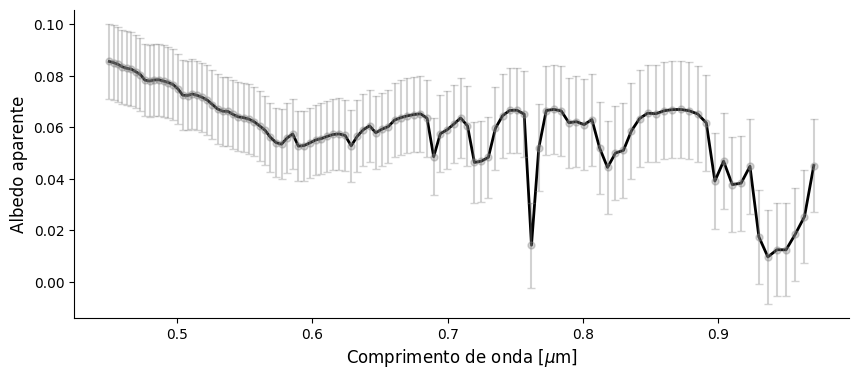

In [8]:
spectrum.plotar_espectro(cor_linha = "k");

## Teste 2 - Mudando as abundâncias

In [ ]:
def novo_valor_gas(dicionario, gas, multiplicador):
    indice_gas = None
    elementos = ['H2O', 'CO2', 'O3', 'N2O', 'CO', 'CH4', 'O2', 'NO', 'SO2', 'NO2', 'NH3', 'HNO3', 'OH', 
                 'HF', 'HCl', 'HBr', 'HI', 'ClO', 'OCS', 'H2CO', 'HOCl', 'N2', 'HCN', 'CH3Cl', 'H2O2', 
                 'C2H2', 'C2H6', 'PH3']
    try:
        indice_gas = elementos.index(gas)
    except ValueError:
        print("Gás não encontrado na lista de elementos.")
        return

    for key, value in dicionario.items():
        if key.startswith("ATMOSPHERE-LAYER-"):
            values = value.split(',')
            valor_gas = float(values[indice_gas + 2])
            novo_valor = valor_gas * (multiplicador)
            values[indice_gas + 2] = str(novo_valor)
            dicionario[key] = ','.join(values)

In [169]:
# Dobrando o valor de O2
config_dobro_O2 = config.copy()
novo_valor_gas(config_dobro_O2, "O2", 2)
resultado_dobro_O2 = psg.run(config_dobro_O2)

In [170]:
# Tirando O2 da atmosfera
config_sem_O2 = config.copy()
novo_valor_gas(config_sem_O2, "O2", 0)
resultado_sem_O2 = psg.run(config_sem_O2)

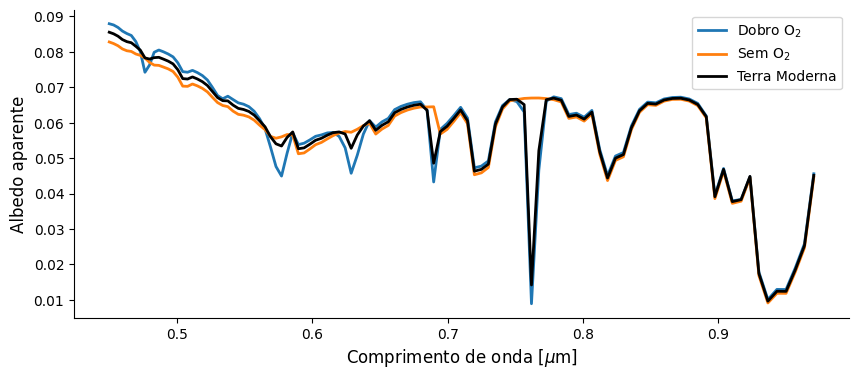

In [171]:
spectrum_dobro_02 = EspectroAnalise(resultado_dobro_O2)
spectrum_sem_02 = EspectroAnalise(resultado_sem_O2)

fig, ax = plt.subplots()
ax = spectrum_dobro_02.plotar_espectro(ax = ax, label = "Dobro O${}_2$", mostrar_erro = False, cor_linha = "tab:blue")
ax = spectrum_sem_02.plotar_espectro(ax = ax, label = "Sem O${}_2$", mostrar_erro = False, cor_linha = "tab:orange")
ax = spectrum.plotar_espectro(ax=ax, label="Terra Moderna", mostrar_erro = False, cor_linha = "k")
ax.legend();

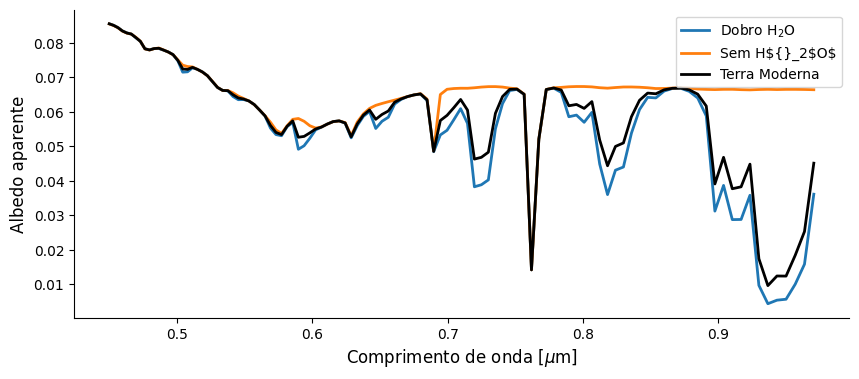

In [173]:
# Dobrando o valor de H2O
config_dobro_H2O = config.copy()
novo_valor_gas(config_dobro_H2O, "H2O", 2)
resultado_dobro_H2O = psg.run(config_dobro_H2O)

# Tirando H2O da atmosfera
config_sem_H2O = config.copy()
novo_valor_gas(config_sem_H2O, "H2O", 0)
resultado_sem_H2O = psg.run(config_sem_H2O)

spectrum_dobro_H2O = EspectroAnalise(resultado_dobro_H2O)
spectrum_sem_H2O = EspectroAnalise(resultado_sem_H2O)

fig, ax = plt.subplots()
ax = spectrum_dobro_H2O.plotar_espectro(ax = ax, label = "Dobro H${}_2$O", mostrar_erro = False, cor_linha = "tab:blue")
ax = spectrum_sem_H2O.plotar_espectro(ax = ax, label = "Sem H${}_2$O$", mostrar_erro = False, cor_linha = "tab:orange")
ax = spectrum.plotar_espectro(ax=ax, label="Terra Moderna", mostrar_erro = False, cor_linha = "k")
ax.legend();

## Teste 3 - Modificando a pressão atmosférica (mbar)

In [ ]:
# 500 mbar = .5 bar
# O espectro não retornou nada para o dobro e 4x a pressão atmosférica
config_metade_atm = config.copy()
modifica_pressao_atmosferica(config_metade_atm, 500)
resultado_metade_atm = psg.run(config_metade_atm)

config_15_atm = config.copy()
modifica_pressao_atmosferica(config_15_atm, 1500)
resultado_15_atm = psg.run(config_15_atm)

In [ ]:
spectrum_metade_atm = EspectroAnalise(resultado_metade_atm)
spectrum_15_atm = EspectroAnalise(resultado_15_atm)

fig, ax = plt.subplots()
ax = spectrum_metade_atm.plotar_espectro(ax = ax, label = "$p = 0.5$ bar", mostrar_erro = False, cor_linha = "tab:blue")
ax = spectrum.plotar_espectro(ax=ax, label = "$p = 1$ bar", mostrar_erro = False, cor_linha = "black")
ax = spectrum_15_atm.plotar_espectro(ax = ax, label = "$p = 1.5$ bar", mostrar_erro = False, cor_linha = "tab:orange")
ax.legend();

Quando a pressão atmosférica diminui, é geralmente um indicativo de uma atmosfera mais rarefeita. Em contrapartida, uma pressão atmosférica mais elevada sugere uma atmosfera mais densa e expansiva. A correlação entre a densidade atmosférica e a visibilidade das assinaturas espectrais está intrinsecamente ligada à interação fóton-molécula. Em uma atmosfera densa, as moléculas presentes têm mais oportunidades de interagir com os fótons, resultando em assinaturas espectrais mais pronunciadas. No entanto, quando a atmosfera é mais rarefeita, essas interações diminuem, levando a uma atenuação significativa das assinaturas espectrais.

## Geração de modelos

Manter o mesmo P-T da Terra e gerar milhares de modelos só mudando a tamanho do planeta, temperatura do planeta.

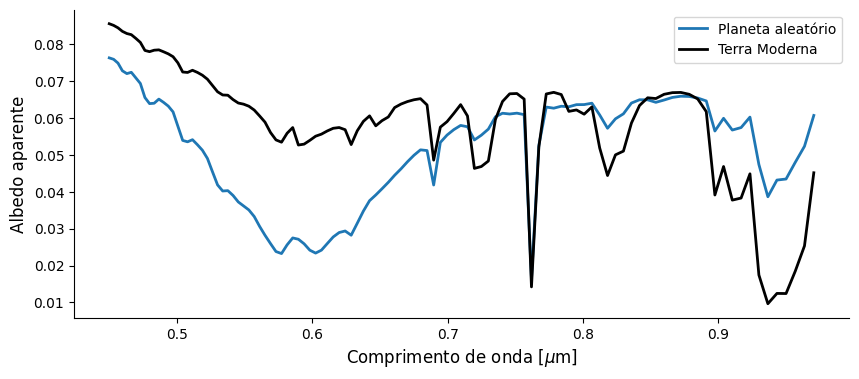

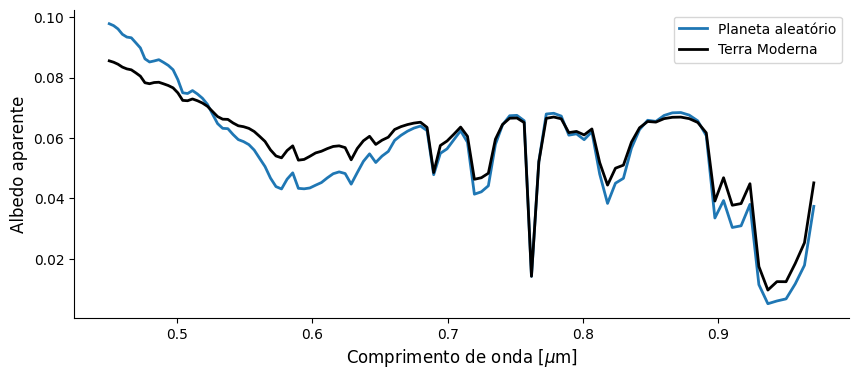

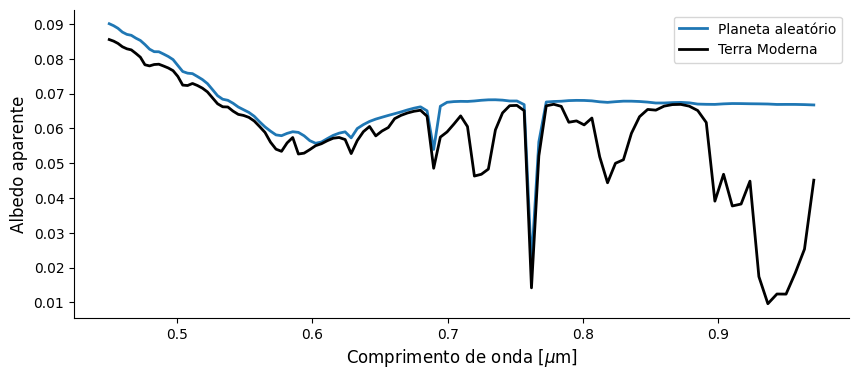

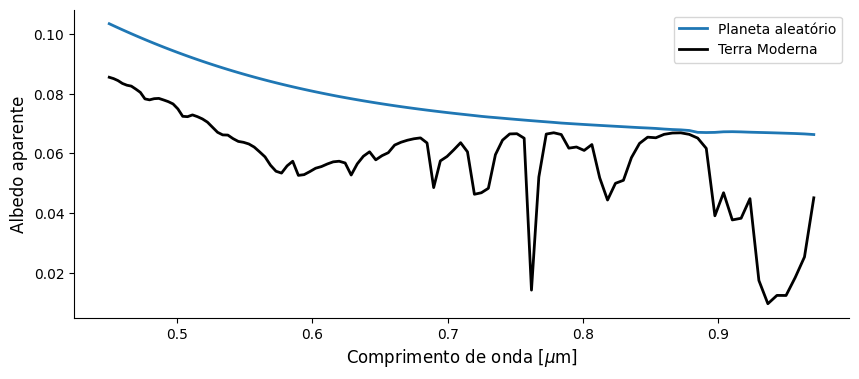

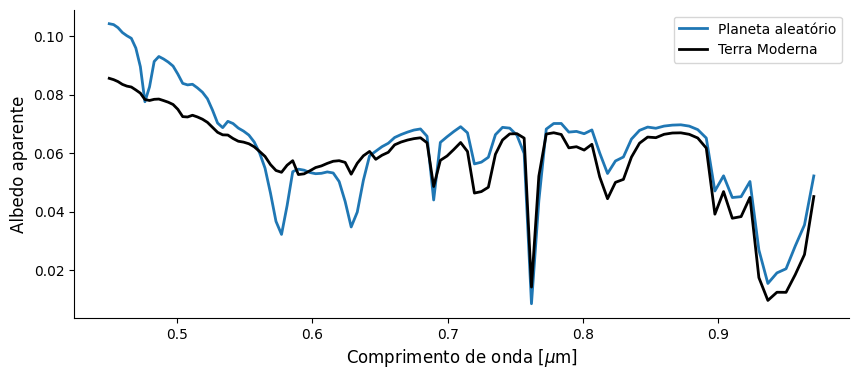

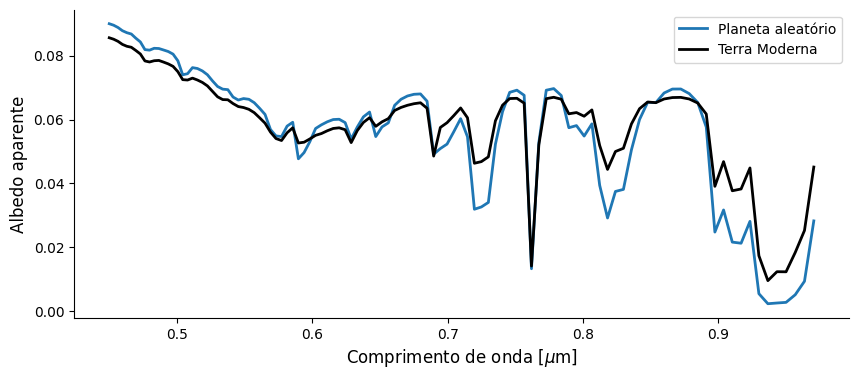

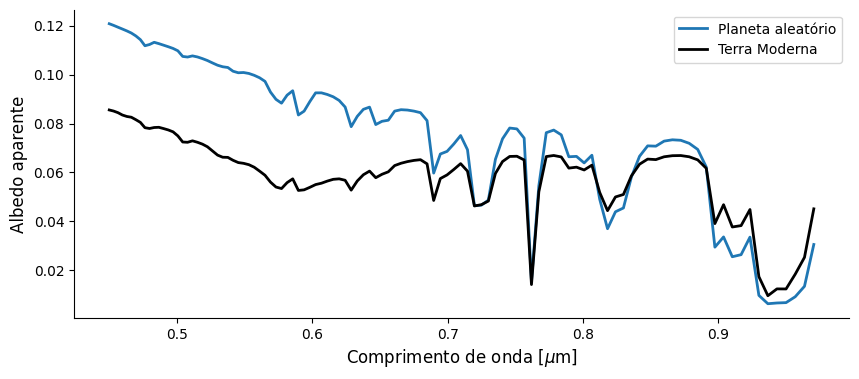

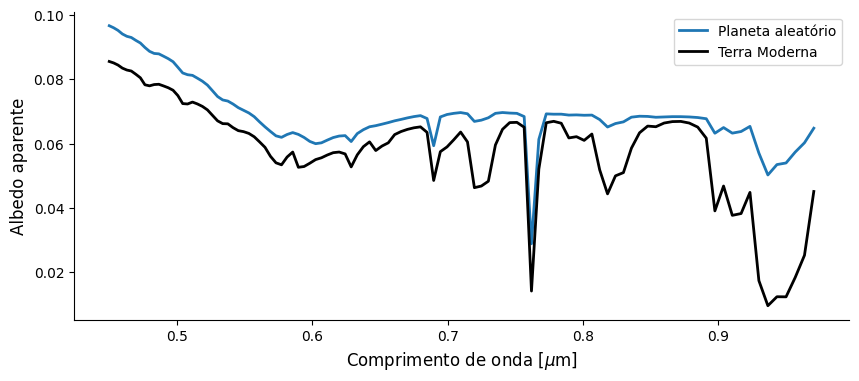

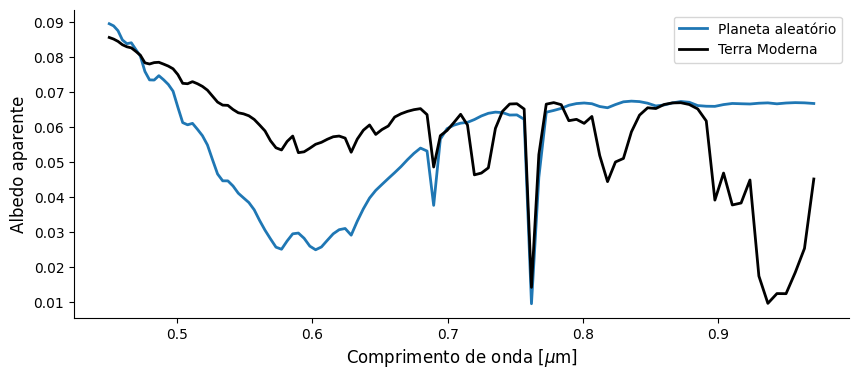

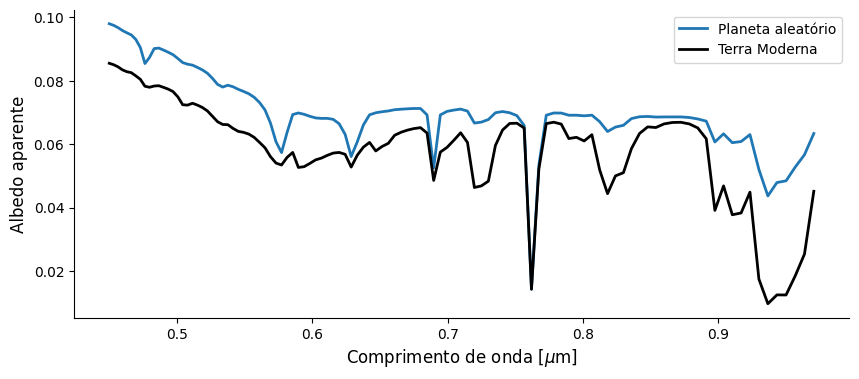

In [174]:
for i in range(10):
    aleatorio = config.copy()
    config_aleatorio(aleatorio)
    resultado_random = psg.run(aleatorio)

    spectrum_random = EspectroAnalise(resultado_random)
    df = spectrum_random.converter_para_dataframe()

    if isinstance(df, pd.core.frame.DataFrame):
        fig, ax = plt.subplots()
        ax = spectrum_random.plotar_espectro(ax = ax, label = "Planeta aleatório", mostrar_erro = False, cor_linha = "tab:blue")
        ax = spectrum.plotar_espectro(ax=ax, label = "Terra Moderna", mostrar_erro = False, cor_linha = "black")
        ax.legend()
        plt.show()
    else:
        print(f'Plot {i} deu ruim')
        continue